In [1]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import tifffile as tiff
import matplotlib.pyplot as plt
import cv2
import matplotlib

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
import pickle
from matplotlib.patches import Polygon
import datetime
import statsmodels.stats.multitest as mlt
#important for text to be detected when importing saved figures into illustrator
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42

In [ ]:
# set paths to results
rootpath = r"...\Data\Figure S5"
threshold_path = os.path.join(rootpath,"thresholds")
meta_path = os.path.join(rootpath,"meta")
figurepath = os.path.join(rootpath,"figures")
summary_path = os.path.join(rootpath,"rawdata")
statspath = os.path.join(rootpath,"stats")


for x in [threshold_path,summary_path,figurepath,statspath]:
    if not os.path.exists(x):
        os.mkdir(x)

In [ ]:
# Excel file to store statistical values for manuscript
manuscript_statistic_filepath = os.path.join(r"...\meta","manuscript_statistic.csv")
manuscript_statistic_file = pd.read_csv(manuscript_statistic_filepath,index_col = False)

In [4]:
# Load the meta data
Fos_mapping_meta = pd.read_csv(os.path.join(meta_path,"metainfo.csv"),index_col = False)

In [5]:
# Load the preprocessed data
# The preprocessed data contains all the cells from all the subjects.
# Individual datas can be discriminated using the ID column.
# The other columns, 'GENE Area (µm²)', 'GENE Avg Intensity', 'GENE Cell Intensity',
# 'GENE Classification', 'GENE Copies', 'GENE regressed_copies', are gene specific datasets.
# 'GENE positive_cells' was determined by a pre-determined threshold for regressed_copies.

# GENE regresed copies is the number of Copies regressed based on the intensity value and Copies data from the same section.
# This is assuimng that the intensity for one copy is the consistent in HCR.

# Data from 5 brain regions, BST (BNST), MPN (MPN), MPA, LPO and VLPO, from each hemisphere is analysed.
# 3 sections, s1 anterior, s2 medial, s3 posterior, are used.

# The most raw data set
merge_df = pd.read_csv(os.path.join(summary_path,'MPOA_female_summary_result.csv'),index_col = False)


In [6]:
# read the mean and count dataframe
meandf = pd.read_csv(os.path.join(summary_path,'MPOA_female_summary_result_mean.csv'),index_col = False)
countdf = pd.read_csv(os.path.join(summary_path,'MPOA_female_summary_result_count.csv'),index_col = False)


In [7]:
# The merge_df dataframe is processed to calculate the average number of cells that are positive

group_columns = ['section','ID','Analysis major region','Sex','Stim','Sex_Stim']
#meandf = merge_df.groupby(group_columns).mean().reset_index() # calculate the number of cells 
#countdf = merge_df.groupby(group_columns).count().reset_index()


In [8]:
new_IDs = [Fos_mapping_meta.loc[Fos_mapping_meta.Original_ID == f,'ID'].values[0] for f in merge_df.ID]

# Figure S3D

c:\Users\stuberadmin\anaconda3\envs\cellpose\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


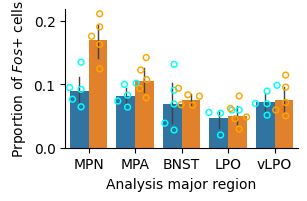

In [9]:
fig ,axs = plt.subplots(1,1,figsize = (3,1.8),sharex = False,sharey = False)
sns.barplot(data = meandf.groupby(['ID','Analysis major region','Stim',]).mean().reset_index(),\
            x = 'Analysis major region', y = 'Fos positive_cells', hue = 'Stim',
order = ['MPN','MPA','BST','LPO','VLPO'],dodge = True,ax = axs,errwidth = 1)
sns.swarmplot(data = meandf.groupby(['ID','Analysis major region','Stim']).mean().reset_index(),\
              x = 'Analysis major region', y = 'Fos positive_cells', hue = 'Stim',
order = ['MPN','MPA','BST','LPO','VLPO'],dodge = True,ax = axs,\
    palette = ['cyan','orange'], marker="$\circ$", ec="face",s = 8)
axs.set_ylabel('Prportion of $\it{Fos}$+ cells')
axs.set_xticklabels(['MPN','MPA','BNST','LPO','vLPO'])
sns.despine()
axs.get_legend().remove()
fig.savefig(os.path.join(figurepath,'FigureS5D.png'),bbox_inches='tight',dpi = 216)
fig.savefig(os.path.join(figurepath,'FigureS5D.pdf'),bbox_inches='tight')    


In [10]:
#perform two-way Students t-test, then correct with Bonferroni correction
from scipy import stats
group1 = 'Appetitive'
group2 = 'Post_ejaculatory'

pvalues = []
statistics = []
tempdf = meandf.groupby(['ID','Analysis major region','Stim',]).mean().reset_index()
for region in meandf['Analysis major region'].unique():
#for region in ['MPN','MPA','BST']:
    statistic,pvalue = stats.ttest_ind(tempdf[(tempdf.Stim == group1)&(tempdf['Analysis major region'] == region)]['Fos positive_cells'],\
                    tempdf[(tempdf.Stim == group2)&(tempdf['Analysis major region'] == region)]['Fos positive_cells'])
    #print(region,pvalue)
    pvalues.append(pvalue)
    statistics.append(statistic)


multiple_ttests_S3D = mlt.multipletests(pvalues,method = 'bonferroni')
(significance,corr_pvals, __ , __ ) = multiple_ttests_S3D
n1 = tempdf[(tempdf.Stim == group1)&(tempdf['Analysis major region'] == region)].shape[0]
n2 = tempdf[(tempdf.Stim == group2)&(tempdf['Analysis major region'] == region)].shape[0]
# print the results
for ridx,region in enumerate(meandf['Analysis major region'].unique()):
    print(region,corr_pvals[ridx])

    # Append the ttest result to manuscript_statistic_file
    ttest_bonferroni_correction = pd.DataFrame([{
        'Figure': 'FigureS5D',
        'variable':f'Proportion of Fos positive_cells',
        'Type of Test': 't-test with BH correction',
        'Detail': f'{region}; {group1} vs {group2}',
        'statistic description': f't({n1 + n2 -2})',  # Showing "n" for each group
        'statistic': statistics[ridx],
        'p Value': corr_pvals[ridx]
    }])
    
    # Concatenate to the results DataFrame
    manuscript_statistic_file = pd.concat([manuscript_statistic_file, ttest_bonferroni_correction], ignore_index=True)

# save results
import pickle
with open(os.path.join(statspath,'FigureS5D_studentsttest_multitest.pickle'), 'wb') as handle:
    pickle.dump(multiple_ttests_S3D, handle, protocol=pickle.HIGHEST_PROTOCOL)


BST 1.0
LPO 1.0
MPA 0.5142071818743981
MPN 0.013604679562290592
VLPO 1.0


# Figure S3I

In [11]:
# The raw dataframe "MPOA_female_summary_result.csv" was processed to subset the cells into Vgat+ or Vglut2+ cells
# Then calculate the proportion of other gene+ cells and the average number of copies per each gene.

result_group_merge_df = pd.read_csv(os.path.join(summary_path,'MPOA_female_Vgat_Vglut2_summary_result.csv'),index_col = False)

In [12]:
# Preprocess the dataset so that it can be easy to plot
result_group_merge_df_stack = result_group_merge_df.set_index(['ID','Analysis major region','Sex','Stim','Sex_Stim']).stack().reset_index().\
rename(columns = {'level_' + str(len(group_columns)-1):'Variable',0:'Value'})
result_group_merge_df_stack['Value'] = result_group_merge_df_stack.Value.astype('float64')
result_group_merge_df_stack = result_group_merge_df_stack.groupby(['ID','Analysis major region','Sex','Stim','Sex_Stim','Variable']).mean().reset_index()

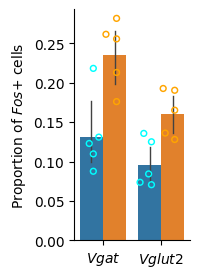

In [13]:
fig,axs = plt.subplots(1,1,figsize = (1.5,3))
sns.swarmplot(data = result_group_merge_df_stack[(result_group_merge_df_stack['Analysis major region'] == 'MPN')&(
    (result_group_merge_df_stack.Variable == 'Vglut2+ Vglut2+ Fos+ positive_cells proportion over gene')|
                                                (result_group_merge_df_stack.Variable == 'Vgat+ Vgat+ Fos+ positive_cells proportion over gene'))].\
              groupby(['ID','Analysis major region','Sex','Stim','Sex_Stim','Variable']).mean().reset_index(),
             hue = 'Stim',y = 'Value', x = 'Variable',dodge = True,ax = axs,
             palette = ['cyan','orange'], marker="$\circ$", ec="face",s = 8)
sns.barplot(data = result_group_merge_df_stack[(result_group_merge_df_stack['Analysis major region'] == 'MPN')&(
    (result_group_merge_df_stack.Variable == 'Vglut2+ Vglut2+ Fos+ positive_cells proportion over gene')|
                                                (result_group_merge_df_stack.Variable == 'Vgat+ Vgat+ Fos+ positive_cells proportion over gene'))].\
              groupby(['ID','Analysis major region','Sex','Stim','Sex_Stim','Variable']).mean().reset_index(),
             hue = 'Stim',y = 'Value', x = 'Variable',dodge = True,ax = axs,errwidth = 1)
axs.set_xticklabels(['$\it{Vgat}$','$\it{Vglut2}$'])
axs.set_ylabel('Proportion of $\it{Fos}$+ cells')
sns.despine()
axs.set_xlabel('')
axs.get_legend().remove()
fig.savefig(os.path.join(figurepath,'FigureS5I.png'),bbox_inches='tight',dpi = 216)
fig.savefig(os.path.join(figurepath,'FigureS5I.pdf'),bbox_inches='tight')    


In [14]:
#perform two-way Students t-test, then correct with Bonferroni correction
from scipy import stats
group1 = 'Appetitive'
group2 = 'Post_ejaculatory'

tempdf = result_group_merge_df_stack[(result_group_merge_df_stack['Analysis major region'] == 'MPN')&(
    (result_group_merge_df_stack.Variable == 'Vglut2+ Vglut2+ Fos+ positive_cells proportion over gene')|
                                                (result_group_merge_df_stack.Variable == 'Vgat+ Vgat+ Fos+ positive_cells proportion over gene'))].\
              groupby(['ID','Analysis major region','Sex','Stim','Sex_Stim','Variable']).mean().reset_index()

pvalues = []
statistics = []

for gene in ['Vglut2','Vgat',]:
    statistic,pvalue = stats.ttest_ind(tempdf[(tempdf.Variable == gene + '+ '+ gene + '+ ' + 'Fos+ positive_cells proportion over gene')
      &(tempdf.Stim == 'Appetitive')].Value,\
tempdf[(tempdf.Variable == gene + '+ '+ gene + '+ ' + 'Fos+ positive_cells proportion over gene')
      &(tempdf.Stim == 'Post_ejaculatory')].Value)
    #print(pvalue)
    pvalues.append(pvalue)
    statistics.append(statistic)

multiple_ttests_S3I = mlt.multipletests(pvalues,method = 'bonferroni')
(significance,corr_pvals, __ , __ ) = multiple_ttests_S3I

# print the results
for gids,gene in enumerate(['Vglut2','Vgat',]):
    print(gene,corr_pvals[gids])
    # Append the ttest result to manuscript_statistic_file
    ttest_bonferroni_correction = pd.DataFrame([{
        'Figure': 'FigureS5I',
        'variable':f'Proportion of Fos positive_cells',
        'Type of Test': 't-test with BH correction',
        'Detail': f'{gene}; {group1} vs {group2}',
        'statistic description': f't({n1 + n2 -2})',  # Showing "n" for each group
        'statistic': statistics[gids],
        'p Value': corr_pvals[gids]
    }])
    
    # Concatenate to the results DataFrame
    manuscript_statistic_file = pd.concat([manuscript_statistic_file, ttest_bonferroni_correction], ignore_index=True)
# save results
import pickle
with open(os.path.join(statspath,'FigureS5I_studentsttest_multitest.pickle'), 'wb') as handle:
    pickle.dump(multiple_ttests_S3I, handle, protocol=pickle.HIGHEST_PROTOCOL)

Vglut2 0.01904205968817266
Vgat 0.015325767916693525


# Figure S3J

c:\Users\stuberadmin\anaconda3\envs\cellpose\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\stuberadmin\anaconda3\envs\cellpose\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


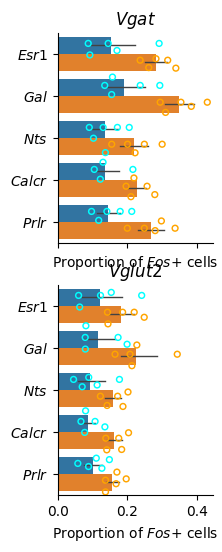

In [15]:
# Specify genes list
genes = ['Fos','Vgat','Vglut2','Esr1','Gal','Nts','Calcr','Prlr']

# Define a variable to store labels for the first subplot
vgat_gene_order = ['Vgat+ ' + gene + '+ Fos+ positive_cells proportion over gene' for gene in genes[3:8]]

# Create the figure and subplots
fig,axs = plt.subplots(2,1,figsize = (2,6),sharex = True,sharey = False)

# Filter the dataframe for the first subplot (Vgat)
Vgat_tempdf = result_group_merge_df_stack[(result_group_merge_df_stack['Analysis major region'] == 'MPN') & \
                                                (result_group_merge_df_stack.Variable.isin(vgat_gene_order))]

# Group the dataframe by 'Stim', 'ID', 'Variable' and take the mean
Vgat_tempdf = Vgat_tempdf.drop(columns=['Analysis major region','Sex_Stim','Sex'])
grouped_df = Vgat_tempdf.groupby(['Stim','ID','Variable']).mean().reset_index()

# Create bar plot and swarm plot for the first subplot (Vgat)
sns.barplot(data=grouped_df, y='Variable', x='Value', hue='Stim', dodge=True, ax=axs[0], order=vgat_gene_order, hue_order=['Appetitive', 'Post_ejaculatory'],errwidth=1)
sns.swarmplot(data=grouped_df, y='Variable', x='Value', hue='Stim', dodge=True, ax=axs[0], order=vgat_gene_order, 
              color=None, edgecolor='k', hue_order=['Appetitive','Post_ejaculatory'], palette=['cyan','orange'], marker="$\circ$", ec="face", s=8)

# Format y-axis labels and remove legend
axs[0].set_yticklabels(['$\it{{{}}}$'.format(f) for f in genes[3:8]])
axs[0].get_legend().remove()

# Repeat similar steps for the second subplot (Vglut2)
Vglut2_gene_order = ['Vglut2+ ' + gene + '+ Fos+ positive_cells proportion over gene' for gene in genes[3:8]]

Vglut2_tempdf = result_group_merge_df_stack[(result_group_merge_df_stack['Analysis major region'] == 'MPN') & \
                                                (result_group_merge_df_stack.Variable.isin(Vglut2_gene_order))]

Vglut2_tempdf = Vglut2_tempdf.drop(columns=['Analysis major region','Sex_Stim','Sex'])
grouped_df = Vglut2_tempdf.groupby(['Stim','ID','Variable']).mean().reset_index()

sns.barplot(data=grouped_df, y='Variable', x='Value', hue='Stim', dodge=True, ax=axs[1], order=Vglut2_gene_order, hue_order=['Appetitive','Post_ejaculatory'],errwidth=1)
sns.swarmplot(data=grouped_df, y='Variable', x='Value', hue='Stim', dodge=True, ax=axs[1], order=Vglut2_gene_order,
              color=None, edgecolor='k', hue_order=['Appetitive','Post_ejaculatory'], palette=['cyan','orange'], marker="$\circ$", ec="face",s = 8)

axs[1].set_yticklabels(['$\it{{{}}}$'.format(f) for f in genes[3:8]])
axs[1].get_legend().remove()

# Format labels and titles for subplots
[ax.set_xlabel('') for ax in axs]
axs[0].set_title('$\it{Vgat}$')
[ax.set_xlabel('Proportion of $\it{Fos}$+ cells') for ax in axs]
[ax.set_ylabel('') for ax in axs]
axs[1].set_title('$\it{Vglut2}$')

# Remove the top and right spines from plot
sns.despine()

fig.savefig(os.path.join(figurepath,'FigureS5J.png'),bbox_inches='tight',dpi = 216)
fig.savefig(os.path.join(figurepath,'FigureS5J.pdf'),bbox_inches='tight')    



In [16]:
from scipy import stats
group1 = 'Appetitive'
group2 = 'Post_ejaculatory'

pvalues = []
statistics = []

tempdf = Vgat_tempdf.groupby(['ID','Stim','Variable']).mean().reset_index()
for variable in tempdf.Variable.unique():
    a = tempdf[(tempdf.Stim == 'Appetitive')&(tempdf.Variable == variable)].Value
    b = tempdf[(tempdf.Stim == 'Post_ejaculatory')&(tempdf.Variable == variable)].Value
    #print(b)
    #print(len(b))
    statistic,pvalue = stats.ttest_ind(a,b)
    #print(variable,pvalue)
    pvalues.append(pvalue)
    statistics.append(statistic)

multiple_ttests_S3J_vgat = mlt.multipletests(pvalues,method = 'bonferroni')

(significance,corr_pvals, __ , __ ) = multiple_ttests_S3J_vgat


# save results
import pickle
with open(os.path.join(statspath,'FigureS5J_Vgat_studentsttest_multitest.pickle'), 'wb') as handle:
    pickle.dump(multiple_ttests_S3J_vgat, handle, protocol=pickle.HIGHEST_PROTOCOL)

# print the results
for vidx,variable in enumerate(tempdf.Variable.unique()):
    print(variable.split(' Fos+')[0],corr_pvals[vidx])
    gene = variable.split(' Fos+')[0]
    # Append the ttest result to manuscript_statistic_file
    ttest_bonferroni_correction = pd.DataFrame([{
        'Figure': 'FigureS5J',
        'variable':f'Proportion of Fos positive_cells',
        'Type of Test': 't-test with BH correction',
        'Detail': f'{gene}; {group1} vs {group2}',
        'statistic description': f't({n1 + n2 -2})',  # Showing "n" for each group
        'statistic': statistics[ridx],
        'p Value': corr_pvals[ridx]
    }])
    
    # Concatenate to the results DataFrame
    manuscript_statistic_file = pd.concat([manuscript_statistic_file, ttest_bonferroni_correction], ignore_index=True)

Vgat+ Calcr+ 0.031794894841769596
Vgat+ Esr1+ 0.06859169121462076
Vgat+ Gal+ 0.017437375809255504
Vgat+ Nts+ 0.14898091230664742
Vgat+ Prlr+ 0.021217356164107297


In [17]:
from scipy import stats
group1 = 'Appetitive'
group2 = 'Post_ejaculatory'

pvalues = []
statistics = []

tempdf = Vglut2_tempdf.groupby(['ID','Stim','Variable']).mean().reset_index()
for variable in tempdf.Variable.unique():
    a = tempdf[(tempdf.Stim == 'Appetitive')&(tempdf.Variable == variable)].Value
    b = tempdf[(tempdf.Stim == 'Post_ejaculatory')&(tempdf.Variable == variable)].Value
    #print(b)
    #print(len(b))
    __,pvalue = stats.ttest_ind(a,b)
    #print(variable,pvalue)
    pvalues.append(pvalue)
    statistics.append(statistic)
multiple_ttests_S3J_vglut2 = mlt.multipletests(pvalues,method = 'bonferroni')

(significance,corr_pvals, __ , __ ) = multiple_ttests_S3J_vglut2

# print the results
for vidx,variable in enumerate(tempdf.Variable.unique()):
    print(variable.split(' Fos+')[0],corr_pvals[vidx])
    gene = variable.split(' Fos+')[0]
    # Append the ttest result to manuscript_statistic_file
    ttest_bonferroni_correction = pd.DataFrame([{
        'Figure': 'FigureS5J',
        'variable':f'Proportion of Fos positive_cells',
        'Type of Test': 't-test with BH correction',
        'Detail': f'{gene}; {group1} vs {group2}',
        'statistic description': f't({n1 + n2 -2})',  # Showing "n" for each group
        'statistic': statistics[ridx],
        'p Value': corr_pvals[ridx]
    }])
    
    # Concatenate to the results DataFrame
    manuscript_statistic_file = pd.concat([manuscript_statistic_file, ttest_bonferroni_correction], ignore_index=True)

# save results
import pickle
with open(os.path.join(statspath,'FigureS5J_Vglut2_studentsttest_multitest.pickle'), 'wb') as handle:
    pickle.dump(multiple_ttests_S3J_vglut2, handle, protocol=pickle.HIGHEST_PROTOCOL)

Vglut2+ Calcr+ 0.01456014319636953
Vglut2+ Esr1+ 0.8222792326903584
Vglut2+ Gal+ 0.12987967509982315
Vglut2+ Nts+ 0.19511106941466022
Vglut2+ Prlr+ 0.1037796107665155


# Figure S3K and S3L

This part will be conducted in R. The result was transferred into the original dataframe.

In [18]:
# The raw dataframe from HALO with the cluster, cluster_name column which identifies the cluster_id from Seurat
regressed_df = pd.read_csv(os.path.join(summary_path,"MPOA_female_summary_regressed_Seurat_MPN.csv"),index_col = False)

In [19]:
# Preprocess so that it can be easy to plot
regressed_grouped_df = regressed_df.groupby(['ID','cluster_name','Stim']).mean().reset_index()

# Define the grouping columns
group_cols = ['ID','cluster_name',]

# Group the data and aggregate the values in col4
grouped = regressed_grouped_df.groupby(group_cols).sum()

# Create a MultiIndex with all possible combinations of the grouping columns
idx = pd.MultiIndex.from_product(
    [regressed_grouped_df[col].unique() for col in group_cols],
    names=group_cols
)

# Reindex the grouped data with the MultiIndex to fill in missing combinations
result = grouped.reindex(idx, fill_value=0).reset_index()
regressed_grouped_df = regressed_df[['ID','Stim']].drop_duplicates().reset_index(drop = True).merge(result,left_on = ['ID','Stim'],right_on = ['ID','Stim'],how = 'left')

c:\Users\stuberadmin\anaconda3\envs\cellpose\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\stuberadmin\anaconda3\envs\cellpose\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


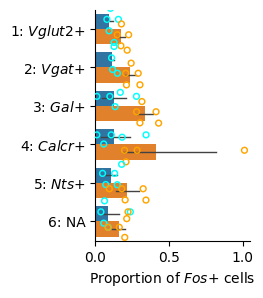

In [20]:
fig,axs = plt.subplots(1,1,figsize = (2,3))
sns.barplot(data = regressed_grouped_df,y = 'cluster_name',x = 'Fos_positive_cells',hue = 'Stim',ax = axs,
order = ['Vglut2+','Vgat+','Gal+','Calcr+','Nts+','N.A.'],errwidth=1)
sns.swarmplot(data = regressed_grouped_df,y = 'cluster_name',x = 'Fos_positive_cells',hue = 'Stim',dodge = True,ax = axs,
order = ['Vglut2+','Vgat+','Gal+','Calcr+','Nts+','N.A.'],palette=['cyan','orange'], marker="$\circ$", ec="face",s = 8)
axs.set_ylabel('')
axs.set_yticklabels([str(idx+1) + ': $\it{{{}}}$+'.format(f) for idx,f in enumerate(['Vglut2','Vgat','Gal','Calcr','Nts'])] + ['6: NA'])
sns.despine()
axs.set_xlabel('Proportion of $\it{Fos}$+ cells')
axs.get_legend().remove()

fig.savefig(os.path.join(figurepath,'FigureS5M.png'),bbox_inches='tight',dpi = 216)
fig.savefig(os.path.join(figurepath,'FigureS5M.pdf'),bbox_inches='tight')    


In [21]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

group1 = 'Appetitive'
group2 = 'Post_ejaculatory'

pvalues = []
statistics = []

clusters = ['Vglut2+','Vgat+','Gal+','Calcr+','Nts+','N.A.']
for cluster in clusters:
    
    a = regressed_grouped_df[(regressed_grouped_df.Stim == 'Appetitive')&(regressed_grouped_df['cluster_name'] == cluster)]['Fos_positive_cells'].values
    b = regressed_grouped_df[(regressed_grouped_df.Stim == 'Post_ejaculatory')&(regressed_grouped_df['cluster_name'] == cluster)]['Fos_positive_cells'].values
    statistic,pvalue = stats.ttest_ind(a,\
                    b)
    #print("Cluster",cluster)
    #print(a,b)
    #print(pvalue)
    pvalues.append(pvalue)
    statistics.append(statistic)

multiple_ttests_S3M = mlt.multipletests(pvalues,method = 'bonferroni')

(significance,corr_pvals, __ , __ ) = multiple_ttests_S3M

# print the results
for cidx,cluster in enumerate(clusters):
    print(cluster,corr_pvals[cidx])

    # Append the ttest result to manuscript_statistic_file
    ttest_bonferroni_correction = pd.DataFrame([{
        'Figure': 'FigureS5M',
        'variable':f'Proportion of Fos positive_cells',
        'Type of Test': 't-test with BH correction',
        'Detail': f'Cluster {cluster}; {group1} vs {group2}',
        'statistic description': f't({n1 + n2 -2})',  # Showing "n" for each group
        'statistic': statistics[ridx],
        'p Value': corr_pvals[ridx]
    }])
    
    # Concatenate to the results DataFrame
    manuscript_statistic_file = pd.concat([manuscript_statistic_file, ttest_bonferroni_correction], ignore_index=True)
# save results
import pickle
with open(os.path.join(statspath,'FigureS5M_studentsttest_multitest.pickle'), 'wb') as handle:
    pickle.dump(multiple_ttests_S3M, handle, protocol=pickle.HIGHEST_PROTOCOL)

Vglut2+ 0.018911145406379108
Vgat+ 0.002166145092146542
Gal+ 0.026480213384107214
Calcr+ 0.9993275659484173
Nts+ 0.37702937392902836
N.A. 0.632230782086898


In [22]:
# Write the stats
manuscript_statistic_file.to_csv(manuscript_statistic_filepath,index = False)